In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch

Utilisation de l'appareil : cuda
Chargement des métadonnées de toutes les instances...


Lecture des fichiers Parquet:   0%|          | 0/1490 [00:00<?, ?it/s]

35760 instances totales trouvées.
Taille Train (original): 25032, Validation: 5364, Test: 5364
\nCréation d'un jeu de données d'entraînement équilibré...


Classification des données d'entraînement:   0%|          | 0/25032 [00:00<?, ?it/s]

Répartition originale (entraînement) : {'Fluide (0-15)': 22335, 'Présaturé (15-30)': 1849, 'Saturé (30-50)': 584, 'Bloqué (>50)': 264}
La limite pour l'équilibrage est de 264 instances par classe.
Nouvelle taille du jeu d'entraînement équilibré : 1056 instances.
\nAjustement du scaler sur les données d'entraînement originales...


Ajustement du scaler:   0%|          | 0/25032 [00:00<?, ?it/s]

Scaler ajusté.
DataLoaders créés. Le set d'entraînement est maintenant équilibré.
Création de la matrice d'adjacence avec décroissance (facteur=0.9)...
Matrice d'adjacence positionnelle et normalisée créée.
Calcul des poids des classes pour la CrossEntropyLoss...


Comptage des classes d'entraînement:   0%|          | 0/1056 [00:00<?, ?it/s]

Poids calculés pour les classes [Fluide, Saturé, Bloqué]: [1. 1. 1. 1.]
DataLoader d'entraînement configuré avec WeightedRandomSampler.
STGNN_K_Classifier(
  (input_layer): Linear(in_features=1, out_features=1024, bias=True)
  (stgcn_blocks): ModuleList(
    (0-2): 3 x STGCN_Block(
      (gcn): GCNLayer(
        (linear): Linear(in_features=1024, out_features=1024, bias=False)
      )
      (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (gru): GRU(1024, 1024, num_layers=2, batch_first=True)
  (time_encoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1040, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=4, bias=True)
  )
)
\nLa fonction de per

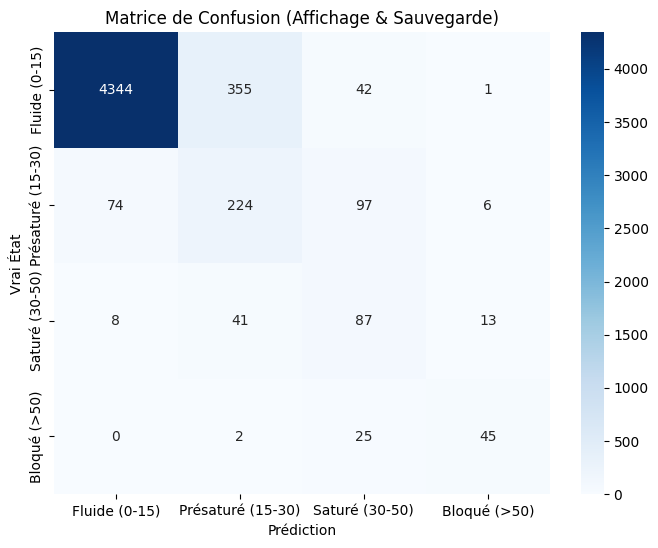

Rapport de métriques sauvegardé dans '/content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/classification_report.txt'

Évaluation et sauvegarde terminées.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import pickle
import torch.nn.functional as F
from tqdm.auto import tqdm

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil : {device}")

# Paramètres
NUM_AMONT = 10
NUM_AVAL = 10
NUM_NODES = 1 + NUM_AMONT + NUM_AVAL
NUM_FEATURES_PER_NODE = 1
OUTPUT_DIM = 1

# Hyperparamètres 
INPUT_DIM_GCN = NUM_FEATURES_PER_NODE
HIDDEN_DIM_GCN = 1024
HIDDEN_DIM_GRU = 1024
NUM_EPOCHS = 200  
EARLY_STOPPING_PATIENCE = 15 
best_val_loss = float('inf')
epochs_no_improve = 0
BATCH_SIZE = 32
LEARNING_RATE = 0.0005

# DATA_DIR = '/content/drive/MyDrive/DATASETS/PFE/donnees_entrainement_k_only_balanced'
DATA_DIR = '/content/drive/MyDrive/DATASETS/PFE/donnees_entrainement_k_24h_history_v2'
TRAFFIC_DATA_LOOKUP_PATH = '/content/drive/MyDrive/DATASETS/PFE/big_data/comptages-clean.parquet' # Pour k(T-1) de l'arc cible
# --- CHEMINS DES FICHIERS SAUVEGARDÉS ---
MODEL_PATH = "stgnn_classifier_model.pth"
FEATURE_SCALER_PATH = "feature_scaler_classifier.joblib"
# TARGET_SCALER_PATH n'est plus utilisé
TEST_METADATA_PATH = "test_metadata_classifier.pkl"
OUTPUT_SAVE_DIR = "/content/drive/MyDrive/ECOLE/ING3/PFE/K_train59"
MODEL_SAVE_PATH = "/content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/stgnn_classifier_final_model.pth"
FEATURE_SCALER_PATH = "/content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/feature_scaler_final.joblib"
TEST_METADATA_PATH = "/content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/test_metadata_final.pkl"


def k_to_bin_label(k_value, bins, labels):
    if pd.isna(k_value):
        return -1 # Retourne un label invalide si la valeur k est manquante
    # pd.cut segmente la valeur k dans les intervalles définis par les 'bins'
    return pd.cut([k_value], bins=bins, labels=labels, right=False, include_lowest=True)[0]

# --- Définitions pour 4 classes ---
NUM_CLASSES = 4
K_BINS = [-float('inf'), 15, 30, 50, float('inf')]
K_BIN_LABELS = [0, 1, 2, 3] # 0: Fluide, 1: Présaturé, 2: Saturé, 3: Bloqué
K_BIN_NAMES = ['Fluide (0-15)', 'Présaturé (15-30)', 'Saturé (30-50)', 'Bloqué (>50)']


# --- 1. CHARGEMENT INITIAL DES MÉTADONNÉES---
print("Chargement des métadonnées de toutes les instances...")
all_parquet_files = glob.glob(os.path.join(DATA_DIR, "*.parquet"))
traffic_lookup_df = pd.read_parquet(TRAFFIC_DATA_LOOKUP_PATH, columns=['iu_ac', 't_1h', 'k'])
traffic_lookup_df['t_1h'] = pd.to_datetime(traffic_lookup_df['t_1h'])
traffic_lookup_df['iu_ac'] = traffic_lookup_df['iu_ac'].astype(str)
traffic_lookup_df = traffic_lookup_df.set_index(['iu_ac', 't_1h'])

all_instances_metadata = []
for file_path in tqdm(all_parquet_files, desc="Lecture des fichiers Parquet"):
    df_meta = pd.read_parquet(file_path, columns=['target_iu_ac', 'target_t', 'features_t'])
    df_meta['target_t'] = pd.to_datetime(df_meta['target_t'])
    df_meta['features_t'] = pd.to_datetime(df_meta['features_t'])
    for idx, row in df_meta.iterrows():
        all_instances_metadata.append({
            'file_path': file_path, 'original_row_index': idx,
            'target_iu_ac': str(row['target_iu_ac']), 'target_t': row['target_t'],
            'features_t': row['features_t']
        })

all_instances_metadata.sort(key=lambda x: x['target_t'])
print(f"{len(all_instances_metadata)} instances totales trouvées.")


# --- 2. SÉPARATION EN TRAIN / VAL / TEST  ---
train_ratio = 0.7
val_ratio = 0.15
num_total = len(all_instances_metadata)
num_train = int(num_total * train_ratio)
num_val = int(num_total * val_ratio)

# On garde de côté les sets de validation et de test originaux
original_train_metadata = all_instances_metadata[:num_train]
val_metadata = all_instances_metadata[num_train : num_train + num_val]
test_metadata = all_instances_metadata[num_train + num_val:]
print(f"Taille Train (original): {len(original_train_metadata)}, Validation: {len(val_metadata)}, Test: {len(test_metadata)}")


# --- 2. SOUS-ÉCHANTILLONNAGE POUR 4 CLASSES ---
print("\\nCréation d'un jeu de données d'entraînement équilibré...")
# Initialisation pour 4 classes ---
metadata_by_class = {0: [], 1: [], 2: [], 3: []}
temp_file_cache = {}
for instance_info in tqdm(original_train_metadata, desc="Classification des données d'entraînement"):
    file_path = instance_info['file_path']
    if file_path not in temp_file_cache:
        temp_file_cache[file_path] = pd.read_parquet(file_path, columns=['target_k'])
    df_file = temp_file_cache[file_path]
    k_target = df_file.iloc[instance_info['original_row_index']]['target_k']
    label = k_to_bin_label(k_target, K_BINS, K_BIN_LABELS)
    if label in metadata_by_class:
        metadata_by_class[label].append(instance_info)
temp_file_cache.clear()

class_counts = {name: len(metadata_by_class[i]) for i, name in enumerate(K_BIN_NAMES)}
print(f"Répartition originale (entraînement) : {class_counts}")

# Logique de sous-échantillonnage robuste ---
if not all(c > 0 for c in class_counts.values()):
    print("AVERTISSEMENT : Au moins une classe n'a aucun échantillon dans le set d'entraînement. L'équilibrage est impossible.")
    train_metadata_balanced = original_train_metadata
else:
    limit = min(class_counts.values())
    print(f"La limite pour l'équilibrage est de {limit} instances par classe.")
    train_metadata_balanced = []
    for i in range(NUM_CLASSES):
        train_metadata_balanced.extend(random.sample(metadata_by_class[i], limit))
    random.shuffle(train_metadata_balanced)
    print(f"Nouvelle taille du jeu d'entraînement équilibré : {len(train_metadata_balanced)} instances.")

# --- 4. AJUSTEMENT DU SCALER (SUR LES DONNÉES ORIGINALES) ---
# Le scaler doit apprendre la distribution réelle des données, donc on l'ajuste
# sur le jeu d'entraînement complet avant sous-échantillonnage.
print("\\nAjustement du scaler sur les données d'entraînement originales...")
all_train_k_features_list = []
adj_k_feature_cols = [f'amont_k_{i}' for i in range(NUM_AMONT)] + [f'aval_k_{i}' for i in range(NUM_AVAL)]
temp_file_cache = {}
for instance_info in tqdm(original_train_metadata, desc="Ajustement du scaler"):
    file_path = instance_info['file_path']
    if file_path not in temp_file_cache:
        temp_file_cache[file_path] = pd.read_parquet(file_path) # Charger toutes les colonnes cette fois
    df_file = temp_file_cache[file_path]
    row_data = df_file.iloc[instance_info['original_row_index']]

    # K des voisins
    for col in adj_k_feature_cols:
        if not pd.isna(row_data.get(col, np.nan)):
            all_train_k_features_list.append(row_data[col])
    # K de l'arc cible à T-1
    try:
        k_target_t_minus_1 = traffic_lookup_df.loc[(str(row_data['target_iu_ac']), row_data['features_t']), 'k']
        if not pd.isna(k_target_t_minus_1):
            all_train_k_features_list.append(k_target_t_minus_1)
    except KeyError:
        pass
temp_file_cache.clear()

feature_scaler = StandardScaler()
feature_scaler.fit(np.array(all_train_k_features_list).reshape(-1, 1))
print("Scaler ajusté.")


class TrafficDatasetK_Classifier(Dataset):
    def __init__(self, instance_metadata_list, traffic_lookup_df,
                 feature_scaler,
                 num_amont, num_aval, padding_value=0.0):
        self.metadata_list = instance_metadata_list
        self.traffic_lookup = traffic_lookup_df
        self.feature_scaler = feature_scaler
        self.num_amont = num_amont
        self.num_aval = num_aval
        self.padding_value = padding_value
        self.loaded_files_cache = {}
        # Les Bins et Labels sont maintenant ceux à 3 classes
        self.K_BINS = [-float('inf'), 15, 30, 50, float('inf')]
        self.K_BIN_LABELS = [0, 1, 2, 3]

    def __len__(self):
        return len(self.metadata_list)

    def __getitem__(self, idx):
        instance_info = self.metadata_list[idx]
        file_path = instance_info['file_path']
        original_row_idx = instance_info['original_row_index']
        target_iu_ac = instance_info['target_iu_ac']
        features_t = instance_info['features_t'] # C'est un objet datetime

        if file_path not in self.loaded_files_cache:
            self.loaded_files_cache[file_path] = pd.read_parquet(file_path)

        row_data = self.loaded_files_cache[file_path].iloc[original_row_idx]

        raw_k_features_nodes = np.full((NUM_NODES, NUM_FEATURES_PER_NODE), self.padding_value, dtype=np.float32)
        try:
            k_target_t_minus_1 = self.traffic_lookup.loc[(target_iu_ac, features_t), 'k']
            raw_k_features_nodes[0, 0] = k_target_t_minus_1 if not pd.isna(k_target_t_minus_1) else self.padding_value
        except (KeyError, AttributeError):
            pass
        for i in range(self.num_amont):
            raw_k_features_nodes[1 + i, 0] = row_data.get(f'amont_k_{i}', self.padding_value)
        for i in range(self.num_aval):
            node_idx = 1 + self.num_amont + i
            raw_k_features_nodes[node_idx, 0] = row_data.get(f'aval_k_{i}', self.padding_value)
        scaled_features_nodes = self.feature_scaler.transform(raw_k_features_nodes)

        # --- NOUVELLE PARTIE : EXTRACTION DES FEATURES TEMPORELLES ---
        # Normalisation pour que les valeurs soient entre -1 et 1 (mieux pour les réseaux de neurones)
        hour = (features_t.hour / 23.0) * 2 - 1
        day_of_week = (features_t.dayofweek / 6.0) * 2 - 1
        time_features = np.array([hour, day_of_week], dtype=np.float32)
        # -----------------------------------------------------------

        raw_k_target = row_data['target_k']
        y_class_label = k_to_bin_label(raw_k_target, self.K_BINS, self.K_BIN_LABELS)

        # Le Dataset retourne maintenant 3 éléments
        return (torch.FloatTensor(scaled_features_nodes).to(device),
        torch.FloatTensor(time_features).to(device),
        torch.LongTensor([y_class_label]).to(device).squeeze())

# --- 2. CRÉATION DES DATALOADERS

# L'appel au constructeur n'inclut plus target_scaler
train_dataset = TrafficDatasetK_Classifier(train_metadata_balanced, traffic_lookup_df, feature_scaler, NUM_AMONT, NUM_AVAL)
val_dataset =   TrafficDatasetK_Classifier(val_metadata, traffic_lookup_df, feature_scaler, NUM_AMONT, NUM_AVAL)
test_dataset =  TrafficDatasetK_Classifier(test_metadata, traffic_lookup_df, feature_scaler, NUM_AMONT, NUM_AVAL)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders créés. Le set d'entraînement est maintenant équilibré.")


# --- 3. DÉFINITION DU MODÈLE ET DE SES COMPOSANTS

def normalize_adj(adj):
    adj_tilde = adj + torch.eye(adj.shape[0], device=adj.device)
    degree_matrix = adj_tilde.sum(1)
    degree_inv_sqrt = torch.pow(degree_matrix, -0.5)
    degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0
    degree_matrix_inv_sqrt = torch.diag(degree_inv_sqrt)
    return torch.mm(degree_matrix_inv_sqrt, torch.mm(adj_tilde, degree_matrix_inv_sqrt))

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
    def forward(self, x, adj):
        x_features_transformed = self.linear(x)
        adj_batch = adj.unsqueeze(0).expand(x.shape[0], -1, -1)
        output = torch.bmm(adj_batch, x_features_transformed)
        return output

class STGCN_Block(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.2):
        super(STGCN_Block, self).__init__()
        self.gcn = GCNLayer(in_features, out_features)
        self.layer_norm = nn.LayerNorm(out_features)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x, adj):
        residual = x
        x = self.gcn(x, adj)
        x = F.relu(x)
        x = self.layer_norm(x)
        x = x + residual
        x = self.dropout(x)
        return x

class STGNN_K_Classifier(nn.Module):
    def __init__(self, num_nodes, in_features_node, hidden_dim,
                 num_classes, num_blocks, gru_num_layers,
                 dropout_rate, normalized_adj):
        super(STGNN_K_Classifier, self).__init__()

        self.input_layer = nn.Linear(in_features_node, hidden_dim)
        self.stgcn_blocks = nn.ModuleList([STGCN_Block(hidden_dim, hidden_dim, dropout_rate) for _ in range(num_blocks)])
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers=gru_num_layers, batch_first=True)
        self.normalized_adj = normalized_adj.to(device)

        # --- NOUVELLE PARTIE : UN PETIT RÉSEAU POUR ENCODER LE TEMPS ---
        time_features_dim = 2 # heure et jour de la semaine
        time_embedding_dim = 16 # Dimension de la représentation temporelle (hyperparamètre)
        self.time_encoder = nn.Sequential(
            nn.Linear(time_features_dim, time_embedding_dim),
            nn.ReLU()
        )
        # ---------------------------------------------------------------

        combined_dim = hidden_dim + time_embedding_dim

        self.output_layer = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim), # Prend la dimension combinée
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x_features_nodes, x_time_features):
        # 1. Traitement du graphe 
        x_graph = self.input_layer(x_features_nodes)
        for block in self.stgcn_blocks:
            x_graph = block(x_graph, self.normalized_adj)
        target_node_features = x_graph[:, 0, :]
        gru_input = target_node_features.unsqueeze(1)
        _, hn = self.gru(gru_input)
        graph_embedding = hn[-1]

        # 2. Traitement des features temporelles
        time_embedding = self.time_encoder(x_time_features)

        # 3. Combinaison des deux types d'informations
        combined_embedding = torch.cat([graph_embedding, time_embedding], dim=1)

        # 4. Classification finale sur les features combinées
        output_logits = self.output_layer(combined_embedding)
        return output_logits

# --- 4. INSTANCIATION DU MODÈLE ET ENTRAÎNEMENT ---

AVAL_WEIGHT = 3       # Poids global pour les arcs avals. 
DECAY_FACTOR = 0.9      # Facteur de décroissance. 

# Créer la matrice d'adjacence avec pondération positionnelle
print(f"Création de la matrice d'adjacence avec décroissance (facteur={DECAY_FACTOR})...")
adj_raw = torch.zeros((NUM_NODES, NUM_NODES), dtype=torch.float32)

# Pondération décroissante pour les arcs AMONT
for i in range(NUM_AMONT):
    distance = i  # amont_0 -> distance=0, amont_1 -> distance=1, etc.
    weight = DECAY_FACTOR ** distance
    node_index = 1 + i # Index du noeud amont dans la matrice
    adj_raw[node_index, 0] = weight

# Pondération décroissante pour les arcs AVAL
for i in range(NUM_AVAL):
    distance = i
    weight = DECAY_FACTOR ** distance
    node_index = 1 + NUM_AMONT + i # Index du noeud aval dans la matrice
    # On applique la décroissance ET le poids global pour l'aval
    adj_raw[0, node_index] = weight * AVAL_WEIGHT

# Rendre la matrice symétrique pour que l'influence soit bidirectionnelle
adj_raw = adj_raw + adj_raw.T

# La fonction de normalisation prendra en compte ces poids nuancés
adj_normalized = normalize_adj(adj_raw)
print("Matrice d'adjacence positionnelle et normalisée créée.")




print("Calcul des poids des classes pour la CrossEntropyLoss...")

# 1. Compter les occurrences de chaque classe dans le set d'entraînement
# Cette opération peut être un peu longue mais n'est faite qu'une seule fois.
train_labels = []
temp_file_cache = {}
for instance_info in tqdm(train_metadata_balanced, desc="Comptage des classes d'entraînement"):
    file_path = instance_info['file_path']
    original_row_idx = instance_info['original_row_index']

    if file_path not in temp_file_cache:
        temp_file_cache[file_path] = pd.read_parquet(file_path, columns=['target_k'])

    df_file = temp_file_cache[file_path]
    k_target = df_file.iloc[original_row_idx]['target_k']

    label = k_to_bin_label(k_target, K_BINS, K_BIN_LABELS)
    train_labels.append(label)

temp_file_cache.clear()

# 2. Calculer les poids
class_counts = np.bincount(train_labels, minlength=len(K_BIN_LABELS))
total_samples = sum(class_counts)
# Formule : poids_classe = total_samples / (nombre_classes * occurrences_classe)
class_weights = total_samples / (len(K_BIN_LABELS) * class_counts)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Poids calculés pour les classes [Fluide, Saturé, Bloqué]: {class_weights_tensor.cpu().numpy()}")


# 1. Assigner un poids à chaque échantillon du train set
sample_weights = [class_weights[label] for label in train_labels]
sample_weights_tensor = torch.DoubleTensor(sample_weights)


print("DataLoader d'entraînement configuré avec WeightedRandomSampler.")

# Le reste de l'instanciation du modèle est correct et ne change pas
model = STGNN_K_Classifier(
    num_nodes=NUM_NODES,
    in_features_node=NUM_FEATURES_PER_NODE,
    hidden_dim=HIDDEN_DIM_GCN,
    num_classes=NUM_CLASSES,
    num_blocks=3,
    gru_num_layers=2,
    dropout_rate=0.2,
    normalized_adj=adj_normalized
).to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\\nLa fonction de perte CrossEntropyLoss utilise maintenant des poids pour contrer le déséquilibre.")

# Initialisation des listes pour sauvegarder l'historique des pertes
train_losses = []
val_losses = []

print("\nDébut de l'entraînement...")

print(f"\\nDébut de l'entraînement (max {NUM_EPOCHS} époques, patience de {EARLY_STOPPING_PATIENCE} époques)...")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0

    # Boucle d'entraînement
    for x_batch, time_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch, time_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Phase de Validation 
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for x_batch_val, time_batch_val, y_batch_val in val_loader:
            outputs_val = model(x_batch_val, time_batch_val)
            loss_val = criterion(outputs_val, y_batch_val)
            epoch_val_loss += loss_val.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Logique d'Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Sauvegarder le meilleur modèle
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  -> Amélioration de la Val Loss. Modèle sauvegardé dans {MODEL_SAVE_PATH}")
    else:
        epochs_no_improve += 1
        print(f"  -> Pas d'amélioration de la Val Loss depuis {epochs_no_improve} époques.")

    if epochs_no_improve == EARLY_STOPPING_PATIENCE:
        print(f"\\nEarly stopping déclenché à l'époque {epoch+1}. Le meilleur modèle a été sauvegardé.")
        break

# Charger le meilleur modèle sauvegardé avant l'évaluation finale
print("\\nChargement du meilleur modèle sauvegardé par Early Stopping pour l'évaluation...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

print("\\nEntraînement terminé.")



# --- CELLULE D'ÉVALUATION FINALE---

print("\n--- Évaluation Finale et Sauvegarde sur l'Ensemble de Test ---")


model.eval()

all_predicted_labels = []
all_true_labels = []

# S'assurer que le test_loader n'est pas vide
if len(test_loader) == 0:
    print("ERREUR: test_loader est vide. Pas d'évaluation possible.")
else:
    with torch.no_grad():
        for x_batch_test, time_batch_test, y_batch_test in test_loader:

            # Le modèle prend maintenant 2 arguments
            output_logits = model(x_batch_test, time_batch_test)

            # Obtenir la classe prédite en prenant l'index du logit maximum
            predicted_classes = torch.argmax(output_logits, dim=1)

            all_predicted_labels.append(predicted_classes.cpu().numpy())
            all_true_labels.append(y_batch_test.cpu().numpy())

    # Concaténer les résultats de tous les batches
    all_predicted_labels = np.concatenate(all_predicted_labels, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    # --- 1. CALCULER TOUTES LES MÉTRIQUES ---


    accuracy = accuracy_score(all_true_labels, all_predicted_labels)

    report_str = classification_report(all_true_labels, all_predicted_labels, target_names=K_BIN_NAMES, zero_division=0)


    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=K_BIN_LABELS)

    # --- 2. AFFICHER LES RÉSULTATS DANS LE NOTEBOOK ---

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nRapport de Classification:")
    print(report_str)

    # Afficher la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=K_BIN_NAMES, yticklabels=K_BIN_NAMES)
    plt.xlabel('Prédiction')
    plt.ylabel('Vrai État')
    plt.title('Matrice de Confusion (Affichage & Sauvegarde)')

    # --- 3. SAUVEGARDER LES MÊMES RÉSULTATS ---

    # Sauvegarder la figure de la matrice de confusion
    plt.savefig(os.path.join(OUTPUT_SAVE_DIR, "confusion_matrix.png"), bbox_inches='tight')
    print(f"\nGraphique de la matrice de confusion sauvegardé dans '{OUTPUT_SAVE_DIR}/confusion_matrix.png'")
    plt.show() 
    plt.close()

    # Sauvegarder le rapport de métriques dans un fichier texte
    with open(os.path.join(OUTPUT_SAVE_DIR, "classification_report.txt"), "w") as f:
        f.write(f"--- Métriques de Classification pour 'k' en Bins - Test Set ---\n")
        f.write(f"  Accuracy: {accuracy:.4f}\n\n")
        f.write("  Rapport de Classification:\n")
        f.write(report_str)
    print(f"Rapport de métriques sauvegardé dans '{OUTPUT_SAVE_DIR}/classification_report.txt'")

print("\nÉvaluation et sauvegarde terminées.")

In [ ]:
import joblib
import pickle

print("\n--- Sauvegarde du Modèle et des Artéfacts pour la Reproductibilité ---")

try:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Modèle sauvegardé avec succès dans : {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Erreur lors de la sauvegarde du modèle : {e}")

try:
    joblib.dump(feature_scaler, FEATURE_SCALER_PATH)
    print(f"Scaler de features sauvegardé avec succès dans : {FEATURE_SCALER_PATH}")
except Exception as e:
    print(f"Erreur lors de la sauvegarde du feature_scaler : {e}")

try:
    with open(TEST_METADATA_PATH, 'wb') as f:
        pickle.dump(test_metadata, f)
    print(f"Métadonnées de test sauvegardées avec succès dans : {TEST_METADATA_PATH}")
except Exception as e:
    print(f"Erreur lors de la sauvegarde des métadonnées de test : {e}")

print("\nSauvegarde terminée. Ces 3 fichiers sont nécessaires pour reproduire l'évaluation.")


--- Sauvegarde du Modèle et des Artéfacts pour la Reproductibilité ---
Modèle sauvegardé avec succès dans : /content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/stgnn_classifier_final_model.pth
Scaler de features sauvegardé avec succès dans : /content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/feature_scaler_final.joblib
Métadonnées de test sauvegardées avec succès dans : /content/drive/MyDrive/ECOLE/ING3/PFE/K_train59/test_metadata_final.pkl

Sauvegarde terminée. Ces 3 fichiers sont nécessaires pour reproduire l'évaluation.


Création d'un jeu de test équilibré pour l'analyse diagnostique (4 classes)...


Classification des données de test:   0%|          | 0/5364 [00:00<?, ?it/s]

Répartition originale (test) : {'Fluide (0-15)': 4742, 'Présaturé (15-30)': 401, 'Saturé (30-50)': 149, 'Bloqué (>50)': 72}
La limite pour l'équilibrage du test est de 72 instances par classe.
Jeu de test équilibré créé avec 288 instances (72 par classe).
\n==================================================
--- Évaluation sur le jeu de test COMPLET (performance réelle) ---


Évaluation (test complet):   0%|          | 0/168 [00:00<?, ?it/s]

\nRapport de Classification (Jeu de Test Réel Non-Équilibré):\n
                   precision    recall  f1-score   support

    Fluide (0-15)       0.98      0.92      0.95      4742
Présaturé (15-30)       0.36      0.56      0.44       401
   Saturé (30-50)       0.35      0.58      0.43       149
     Bloqué (>50)       0.69      0.62      0.66        72

         accuracy                           0.88      5364
        macro avg       0.60      0.67      0.62      5364
     weighted avg       0.91      0.88      0.89      5364



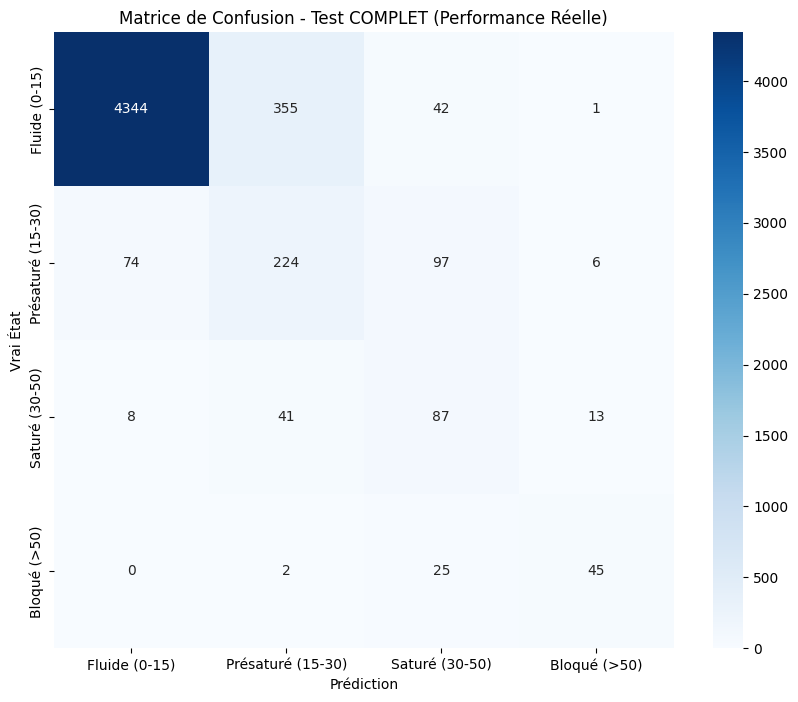

\n==================================================
--- Évaluation sur le jeu de test ÉQUILIBRÉ (pour diagnostic) ---


Évaluation (test équilibré):   0%|          | 0/9 [00:00<?, ?it/s]

\nRapport de Classification (Jeu de Test Équilibré):\n
                   precision    recall  f1-score   support

    Fluide (0-15)       0.84      0.92      0.87        72
Présaturé (15-30)       0.60      0.61      0.61        72
   Saturé (30-50)       0.52      0.61      0.56        72
     Bloqué (>50)       0.88      0.62      0.73        72

         accuracy                           0.69       288
        macro avg       0.71      0.69      0.69       288
     weighted avg       0.71      0.69      0.69       288



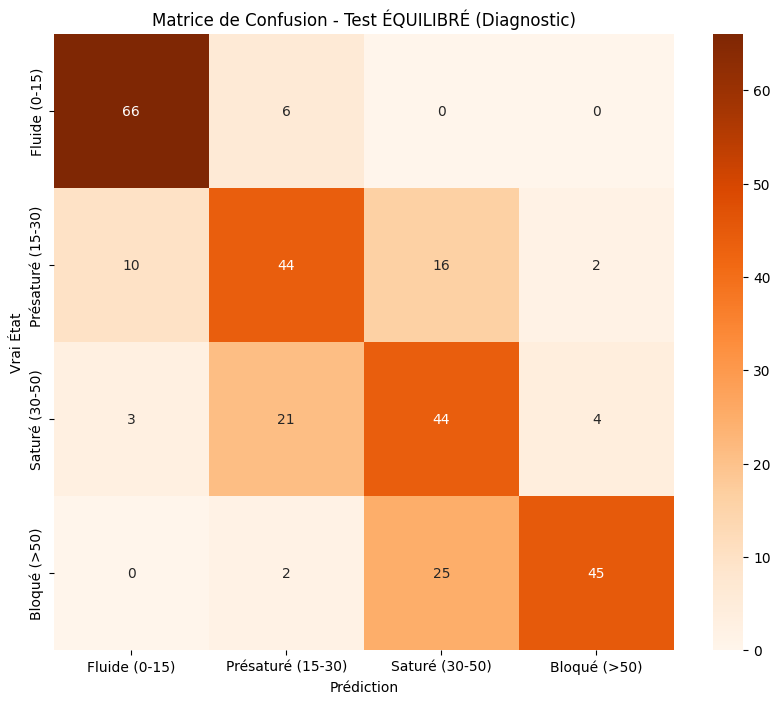

In [ ]:
# --- CELLULE D'ÉVALUATION FINALE ---
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import os

os.makedirs(OUTPUT_SAVE_DIR, exist_ok=True)

# --- Étape 1 : Créer une version équilibrée du jeu de test ---

print("Création d'un jeu de test équilibré pour l'analyse diagnostique (4 classes)...")


test_metadata_by_class = {0: [], 1: [], 2: [], 3: []} # 0: Fluide, 1: Présaturé, 2: Saturé, 3: Bloqué
temp_file_cache = {}

for instance_info in tqdm(test_metadata, desc="Classification des données de test"):
    file_path = instance_info['file_path']
    if file_path not in temp_file_cache:
        temp_file_cache[file_path] = pd.read_parquet(file_path, columns=['target_k'])
    df_file = temp_file_cache[file_path]
    k_target = df_file.iloc[instance_info['original_row_index']]['target_k']

    label = k_to_bin_label(k_target, K_BINS, K_BIN_LABELS)
    if label in test_metadata_by_class:
        test_metadata_by_class[label].append(instance_info)
temp_file_cache.clear()

class_counts_test = {name: len(test_metadata_by_class[i]) for i, name in enumerate(K_BIN_NAMES)}
print(f"Répartition originale (test) : {class_counts_test}")


if all(c > 0 for c in class_counts_test.values()):
    test_limit = min(class_counts_test.values())
    print(f"La limite pour l'équilibrage du test est de {test_limit} instances par classe.")

    test_metadata_balanced = []
    for i in range(NUM_CLASSES):
         test_metadata_balanced.extend(random.sample(test_metadata_by_class[i], test_limit))

    random.shuffle(test_metadata_balanced)

    # Créer un nouveau Dataset et DataLoader pour le test équilibré
    test_dataset_balanced = TrafficDatasetK_Classifier(test_metadata_balanced, traffic_lookup_df, feature_scaler, NUM_AMONT, NUM_AVAL)
    test_loader_balanced = DataLoader(test_dataset_balanced, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Jeu de test équilibré créé avec {len(test_metadata_balanced)} instances ({test_limit} par classe).")
else:
    print("AVERTISSEMENT : Au moins une classe est absente du set de test, impossible de créer un test équilibré.")
    test_loader_balanced = None


# --- Étape 2 : Évaluation sur le jeu de test COMPLET (Non-équilibré) ---
print("\\n" + "="*50)
print("--- Évaluation sur le jeu de test COMPLET (performance réelle) ---")
print("="*50)

model.eval()
all_predicted_labels_imbalanced = []
all_true_labels_imbalanced = []

with torch.no_grad():
    for x_batch, time_batch, y_batch in tqdm(test_loader, desc="Évaluation (test complet)"):
        outputs = model(x_batch, time_batch)
        predicted_classes = torch.argmax(outputs, dim=1)
        all_predicted_labels_imbalanced.extend(predicted_classes.cpu().numpy())
        all_true_labels_imbalanced.extend(y_batch.cpu().numpy())


report_imbalanced_str = classification_report(
    all_true_labels_imbalanced, all_predicted_labels_imbalanced, target_names=K_BIN_NAMES, labels=K_BIN_LABELS, zero_division=0
)
print("\\nRapport de Classification (Jeu de Test Réel Non-Équilibré):\\n")
print(report_imbalanced_str)


cm_imbalanced = confusion_matrix(all_true_labels_imbalanced, all_predicted_labels_imbalanced, labels=K_BIN_LABELS)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_imbalanced, annot=True, fmt='d', cmap='Blues', xticklabels=K_BIN_NAMES, yticklabels=K_BIN_NAMES)
plt.title("Matrice de Confusion - Test COMPLET (Performance Réelle)")
plt.xlabel("Prédiction")
plt.ylabel("Vrai État")
plt.show()


# --- Étape 3 : Évaluation sur le jeu de test ÉQUILIBRÉ (pour diagnostic) ---
if test_loader_balanced:
    print("\\n" + "="*50)
    print("--- Évaluation sur le jeu de test ÉQUILIBRÉ (pour diagnostic) ---")
    print("="*50)

    all_predicted_labels_balanced = []
    all_true_labels_balanced = []

    with torch.no_grad():
        for x_batch, time_batch, y_batch in tqdm(test_loader_balanced, desc="Évaluation (test équilibré)"):
            outputs = model(x_batch, time_batch)
            predicted_classes = torch.argmax(outputs, dim=1)
            all_predicted_labels_balanced.extend(predicted_classes.cpu().numpy())
            all_true_labels_balanced.extend(y_batch.cpu().numpy())

    report_balanced_str = classification_report(
        all_true_labels_balanced, all_predicted_labels_balanced, target_names=K_BIN_NAMES, labels=K_BIN_LABELS, zero_division=0
    )
    print("\\nRapport de Classification (Jeu de Test Équilibré):\\n")
    print(report_balanced_str)

    cm_balanced = confusion_matrix(all_true_labels_balanced, all_predicted_labels_balanced, labels=K_BIN_LABELS)
    plt.figure(figsize=(10, 8)) # 
    sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Oranges', xticklabels=K_BIN_NAMES, yticklabels=K_BIN_NAMES)
    plt.title("Matrice de Confusion - Test ÉQUILIBRÉ (Diagnostic)")
    plt.xlabel("Prédiction")
    plt.ylabel("Vrai État")
    plt.show()